<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/ETA-Prediction/TransitLK_ETA_COO_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup & Data Loading**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import warnings
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
warnings.filterwarnings('ignore')

#upload multiple CSV files
from google.colab import files
print("Upload your GPS tracking CSV files:")
uploaded = files.upload()

#bus stops coordinates
STOPS_RATMALANA_TO_BAMBALAPITIYA = {
    'Golumadama Junction': (6.810710433346013, 79.88234748854951),
    'Belekkade Junction': (6.8146479033245635, 79.8786692065216),
    'Vijitha Halt': (6.817364226961181, 79.87515452515784),
    'Maliban Junction': (6.8194577635422124, 79.87356021650437),
    'Lalanka Ratmalana': (6.823173544815911, 79.87089474281404),
    'Mount Lavinia Police': (6.825433076668215, 79.8697448676328),
    'Hena Road': (6.827617966613862, 79.86882974754288),
    'Templers Road': (6.829886421994827, 79.86792953598227),
    'Mount Lavinia': (6.833045356006737, 79.8672686549206),
    'Mount Lavinia Court': (6.837786821228232, 79.86744519979364),
    'Hotel Road': (6.841953093983693, 79.86681483570858),
    'Cemetery Odeon': (6.844687001271335, 79.86624066452525),
    'Dehiwala Arpico': (6.848879893559448, 79.86590953737266),
    'Dehiwala Junction': (6.851828715024246, 79.86582328306689),
    'Holy Family Convent': (6.857468319954902, 79.86482602887749),
    'Dehiwala Municipal Council': (6.860582711248441, 79.8641225998664),
    'Roxy Gardens': (6.865106324084456, 79.86314173387338),
    'Wellawatte Arpico': (6.8682853649914275, 79.862428435965),
    'Wellawatte Junction': (6.874023870852789, 79.86131857372347),
    'Wellawatte Mosque': (6.876563055661567, 79.86056854446126),
    'St Peters College Bambalapitiya': (6.881175353490238, 79.8592262906708),
    'Bambalapitiya Flats': (6.883890855756892, 79.85844491547076),
    'Vishaka Halt': (6.889274548319365, 79.85685837407006),
    'Bambalapitiya Junction': (6.893351808564476, 79.855543129179)
}

STOPS_BAMBALAPITIYA_TO_RATMALANA = {
    'Bambalapitiya Junction': (6.89421833503331, 79.85743403491827),
    'Vishaka Halt': (6.89173101441345, 79.8584053406695),
    'ICBT Halt': (6.889393164214705, 79.8590995087839),
    'Hindu College Halt': (6.884334511228433, 79.86070021206346),
    'St Peters College Bambalapitiya': (6.881086292650558, 79.8617310945956),
    'Savoy Cinema': (6.878835594116245, 79.86009414378748),
    'Wellawatte Mosque': (6.8771052996116175, 79.86059155256277),
    'Wellawatte Junction': (6.872737657676879, 79.86178650617411),
    'Mangala Halt': (6.8692420950487625, 79.86241265699829),
    'Bodhirukkarama Road': (6.867136549076562, 79.86287715406156),
    'Sampath Bank': (6.863900146136533, 79.86355735448383),
    'Dehiwala Municipal Council': (6.860955823546713, 79.86419762016793),
    'Waidya Road': (6.857253482269844, 79.86503874198182),
    'Dehiwala Junction': (6.850799164629326, 79.86604776762717),
    'Dehiwala Arpico': (6.846449249637398, 79.86620254157684),
    'Cemetery Odeon Halt': (6.844567214152192, 79.86638914094856),
    'Hotel Road': (6.840839172206239, 79.86731964153903),
    'Mount Lavinia Court': (6.838936668749608, 79.86760275370851),
    'Mount Lavinia': (6.835397391774186, 79.86747652243051),
    'Templers Road': (6.8299294447021595, 79.86810987892238),
    'Hena Road': (6.8281855997807135, 79.86877146177072),
    'Mount Lavinia Police': (6.825727535178407, 79.86978457126469),
    'Maliban Junction': (6.82127469622858, 79.8724412976936),
    'Vijitha Halt': (6.817455615075621, 79.87531600011668),
    'Belekkade Junction': (6.815648653029313, 79.87772014801567),
    'Ratmalana Airport': (6.812204148716779, 79.88141611315496),
    'Golumadama Junction': (6.80942743800072, 79.88337382556504)
}

#key stops for model focus (Maliban Junction to Wellawatte Junction)
KEY_STOPS_R2B = ['Maliban Junction', 'Lalanka Ratmalana', 'Mount Lavinia Police', 'Hena Road',
                 'Templers Road', 'Mount Lavinia', 'Mount Lavinia Court', 'Hotel Road',
                 'Cemetery Odeon', 'Dehiwala Arpico', 'Dehiwala Junction', 'Holy Family Convent',
                 'Dehiwala Municipal Council', 'Roxy Gardens', 'Wellawatte Arpico', 'Wellawatte Junction']

KEY_STOPS_B2R = ['Wellawatte Junction', 'Mangala Halt', 'Bodhirukkarama Road', 'Sampath Bank',
                 'Dehiwala Municipal Council', 'Waidya Road', 'Dehiwala Junction', 'Dehiwala Arpico',
                 'Cemetery Odeon Halt', 'Hotel Road', 'Mount Lavinia Court', 'Mount Lavinia',
                 'Templers Road', 'Hena Road', 'Mount Lavinia Police', 'Maliban Junction']

DETECTION_RADIUS = 50  #meters

print(f"Loaded {len(STOPS_RATMALANA_TO_BAMBALAPITIYA)} stops for Ratmalana -> Bambalapitiya")
print(f"Loaded {len(STOPS_BAMBALAPITIYA_TO_RATMALANA)} stops for Bambalapitiya -> Ratmalana")

Upload your GPS tracking CSV files:


Saving TransitLK_1770114296072.csv to TransitLK_1770114296072 (6).csv
Saving TransitLK_1768712545951.csv to TransitLK_1768712545951 (6).csv
Saving TransitLK_1768705904623.csv to TransitLK_1768705904623 (6).csv
Saving TransitLK_1769482275640.csv to TransitLK_1769482275640 (6).csv
Saving TransitLK_1770085942785.csv to TransitLK_1770085942785 (6).csv
Saving TransitLK_1769141577728.csv to TransitLK_1769141577728 (6).csv
Saving TransitLK_1769565884989.csv to TransitLK_1769565884989 (6).csv
Saving TransitLK_1769653755416.csv to TransitLK_1769653755416 (6).csv
Loaded 24 stops for Ratmalana -> Bambalapitiya
Loaded 27 stops for Bambalapitiya -> Ratmalana


## **Helper Functions**



In [41]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points on earth (in meters)
    """
    R = 6371000  #earth radius in meters

    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    distance = R * c
    return distance

def detect_route_direction(df):
    """
    Detect if route is Ratmalana->Bambalapitiya or Bambalapitiya->Ratmalana
    Based on general movement direction (latitude trend)
    """
    #calculate average latitude change
    lat_start = df['lat'].iloc[:10].mean()
    lat_end = df['lat'].iloc[-10:].mean()

    if lat_end > lat_start:
        return 'R2B', STOPS_RATMALANA_TO_BAMBALAPITIYA, KEY_STOPS_R2B
    else:
        return 'B2R', STOPS_BAMBALAPITIYA_TO_RATMALANA, KEY_STOPS_B2R

def find_nearest_stop(lat, lon, stops_dict, key_stops, max_distance=DETECTION_RADIUS):
    """
    Find the nearest stop within detection radius
    Returns (stop_name, distance) or (None, None)
    """
    min_distance = float('inf')
    nearest_stop = None

    for stop_name, (stop_lat, stop_lon) in stops_dict.items():
        if stop_name not in key_stops:
            continue

        distance = haversine_distance(lat, lon, stop_lat, stop_lon)

        if distance < min_distance and distance <= max_distance:
            min_distance = distance
            nearest_stop = stop_name

    return nearest_stop, min_distance if nearest_stop else None


##**Data Loading and Labeling**

In [42]:
print("Loading and Processing GPS Data")


all_data = []

for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")

    #load CSV
    df = pd.read_csv(filename)
    print(f"  Loaded {len(df)} GPS points")

    #cetect route direction
    direction, stops_dict, key_stops = detect_route_direction(df)
    print(f"  Detected route: {direction}")

    #add stop labels
    df['stop_name'] = None
    df['distance_to_stop'] = None
    df['at_stop'] = 0  #binary label: 1 if at stop, 0 otherwise

    stop_detections = {}

    for idx, row in df.iterrows():
        stop_name, distance = find_nearest_stop(row['lat'], row['lng'], stops_dict, key_stops)

        if stop_name:
            df.at[idx, 'stop_name'] = stop_name
            df.at[idx, 'distance_to_stop'] = distance
            df.at[idx, 'at_stop'] = 1

            if stop_name not in stop_detections:
                stop_detections[stop_name] = 0
            stop_detections[stop_name] += 1

    print(f"  Detected {len(stop_detections)} stops:")
    for stop, count in sorted(stop_detections.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"    - {stop}: {count} points")

    all_data.append(df)

#combine all data
combined_df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal combined data: {len(combined_df)} GPS points")
print(f"Points at stops: {combined_df['at_stop'].sum()}")
print(f"Points not at stops: {len(combined_df) - combined_df['at_stop'].sum()}")

Loading and Processing GPS Data

Processing: TransitLK_1770114296072 (6).csv
  Loaded 2273 GPS points
  Detected route: B2R
  Detected 16 stops:
    - Wellawatte Junction: 141 points
    - Dehiwala Junction: 120 points
    - Waidya Road: 51 points
    - Mangala Halt: 42 points
    - Mount Lavinia Court: 42 points

Processing: TransitLK_1768712545951 (6).csv
  Loaded 1820 GPS points
  Detected route: B2R
  Detected 16 stops:
    - Wellawatte Junction: 296 points
    - Dehiwala Junction: 74 points
    - Bodhirukkarama Road: 62 points
    - Hotel Road: 35 points
    - Mount Lavinia: 35 points

Processing: TransitLK_1768705904623 (6).csv
  Loaded 1774 GPS points
  Detected route: R2B
  Detected 16 stops:
    - Dehiwala Junction: 93 points
    - Dehiwala Municipal Council: 75 points
    - Hotel Road: 71 points
    - Mount Lavinia Court: 66 points
    - Wellawatte Junction: 62 points

Processing: TransitLK_1769482275640 (6).csv
  Loaded 1896 GPS points
  Detected route: R2B
  Detected 16 sto

## **Exploratory Data Analysis (EDA)**


Exploratory Data Analysis

1. Dataset Info:
Shape: (16055, 16)
Columns: ['timestamp', 'lat', 'lng', 'altitude', 'speed_mps', 'accuracy', 'satellites', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'stop_name', 'distance_to_stop', 'at_stop']

2. Missing Values:
timestamp               0
lat                     0
lng                     0
altitude                0
speed_mps               0
accuracy                0
satellites              0
ax                      0
ay                      0
az                      0
gx                      0
gy                      0
gz                      0
stop_name           10748
distance_to_stop    10748
at_stop                 0
dtype: int64

3. Class Distribution (At Stop vs Not At Stop):
at_stop
0    10748
1     5307
Name: count, dtype: int64

Stop detection rate: 33.06%


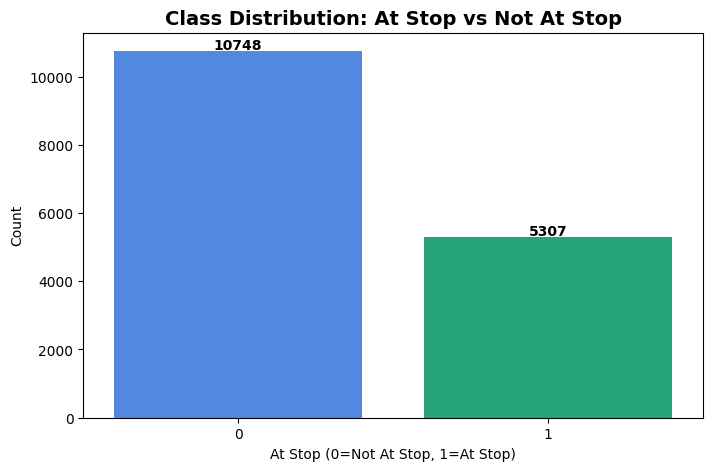


4. GPS and Sensor Statistics:
                lat           lng     speed_mps      accuracy            ax  \
count  16055.000000  16055.000000  16055.000000  16055.000000  16055.000000   
mean       6.850208     79.866005      3.648801      9.538715      0.627123   
std        0.019273      0.004540      3.193155      2.513423      1.879475   
min        6.809124     79.855510      0.000000      3.010000     -9.467502   
25%        6.834368     79.862856      0.520000      9.935000     -0.551994   
50%        6.851429     79.865919      3.156000      9.943000      0.384048   
75%        6.866665     79.867395      6.078246     10.153000      1.561018   
max        6.893307     79.883412     15.150000    150.000000     13.655839   

                 ay            az            gx            gy            gz  
count  16055.000000  16055.000000  16055.000000  16055.000000  16055.000000  
mean       2.327403      5.164537     -0.158398     -0.054180     -0.112345  
std        3.737653    

In [43]:
print("\n" + "="*60)
print("Exploratory Data Analysis")
print("="*60)

print("\n1. Dataset Info:")
print(f"Shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")

print("\n2. Missing Values:")
print(combined_df.isnull().sum())

print("\n3. Class Distribution (At Stop vs Not At Stop):")
stop_counts = combined_df['at_stop'].value_counts()
print(stop_counts)
print(f"\nStop detection rate: {stop_counts.get(1, 0)/len(combined_df):.2%}")

#visualize class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=stop_counts.index, y=stop_counts.values, palette=['#3b82f6','#10b981'])
plt.title('Class Distribution: At Stop vs Not At Stop', fontsize=14, fontweight='bold')
plt.xlabel('At Stop (0=Not At Stop, 1=At Stop)')
plt.ylabel('Count')
for i, v in enumerate(stop_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.show()

print("\n4. GPS and Sensor Statistics:")
numeric_cols = ['lat', 'lng', 'speed_mps', 'accuracy', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']
print(combined_df[numeric_cols].describe())

## **Data Preprocessing**

In [44]:
print("Data Cleaning & Preprocessing")

df_clean = combined_df.copy()

print(f"\n1. Dataset shape: {df_clean.shape}")

#handle missing values
print("\n2. Handling missing values...")
missing_before = df_clean.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

#fill numeric columns with median
numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

missing_after = df_clean.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

#separate features and target
print("\n3. Separating features and target...")

#core mobile sensor features
MOBILE_FEATURES = [
    'lat', 'lng', 'speed_mps', 'accuracy',
    'ax', 'ay', 'az', 'gx', 'gy', 'gz'
]

#remove rows with missing target
df_clean = df_clean.dropna(subset=['at_stop'])

X = df_clean[MOBILE_FEATURES]
y = df_clean['at_stop']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {MOBILE_FEATURES}")


Data Cleaning & Preprocessing

1. Dataset shape: (16055, 16)

2. Handling missing values...
Missing values before: 21496
Missing values after: 21496

3. Separating features and target...
Feature matrix shape: (16055, 10)
Target vector shape: (16055,)
Features: ['lat', 'lng', 'speed_mps', 'accuracy', 'ax', 'ay', 'az', 'gx', 'gy', 'gz']


##**Feature Engineering**

In [45]:
print("Feature Engineering")

X_engineered = X.copy()

#acceleration magnitude (total G-force)
X_engineered['accel_magnitude'] = np.sqrt(
    X_engineered['ax']**2 + X_engineered['ay']**2 + X_engineered['az']**2
)

#gyroscope magnitude (total rotation)
X_engineered['gyro_magnitude'] = np.sqrt(
    X_engineered['gx']**2 + X_engineered['gy']**2 + X_engineered['gz']**2
)
#speed features
X_engineered['speed_kmh'] = X_engineered['speed_mps'] * 3.6  # Convert to km/h
X_engineered['is_slow'] = (X_engineered['speed_mps'] < 2.0).astype(int)  # Speed < 2 m/s
X_engineered['is_stopped'] = (X_engineered['speed_mps'] < 0.5).astype(int)  # Nearly stopped

#movement smoothness (jerk approximation using acceleration change)
X_engineered['accel_jerk'] = X_engineered['accel_magnitude'].diff().abs().fillna(0)

#GPS accuracy indicator
X_engineered['high_accuracy'] = (X_engineered['accuracy'] < 10).astype(int)

print("\nEngineered features:")
print("1. accel_magnitude - Total acceleration force")
print("2. gyro_magnitude - Total rotation force")
print("3. speed_kmh - Speed in km/h")
print("4. is_slow - Binary: speed < 2 m/s")
print("5. is_stopped - Binary: speed < 0.5 m/s")
print("6. accel_jerk - Rate of acceleration change")
print("7. high_accuracy - Binary: GPS accuracy < 10m")

#final feature set
FINAL_FEATURES = MOBILE_FEATURES + [
    'accel_magnitude', 'gyro_magnitude', 'speed_kmh',
    'is_slow', 'is_stopped', 'accel_jerk', 'high_accuracy'
]

X_final = X_engineered[FINAL_FEATURES]

print(f"\nFinal feature matrix: {X_final.shape}")
print(f"Total features: {len(FINAL_FEATURES)}")

Feature Engineering

Engineered features:
1. accel_magnitude - Total acceleration force
2. gyro_magnitude - Total rotation force
3. speed_kmh - Speed in km/h
4. is_slow - Binary: speed < 2 m/s
5. is_stopped - Binary: speed < 0.5 m/s
6. accel_jerk - Rate of acceleration change
7. high_accuracy - Binary: GPS accuracy < 10m

Final feature matrix: (16055, 17)
Total features: 17


##**Handle Class Imbalance**

Balancing Class Distribution

Before balancing:
at_stop
0    10748
1     5307
Name: count, dtype: int64
Imbalance ratio: 2.03:1

After SMOTE balancing:
at_stop
0    10748
1    10748
Name: count, dtype: int64
New shape: (21496, 17)


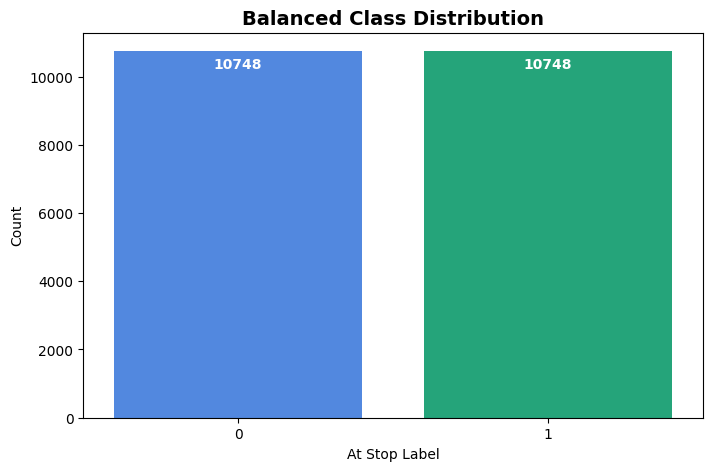

In [46]:
print("Balancing Class Distribution")

print(f"\nBefore balancing:")
print(y.value_counts())
print(f"Imbalance ratio: {y.value_counts()[0] / y.value_counts().get(1, 1):.2f}:1")

#check if we have enough samples for SMOTE
if y.sum() >= 5:  # Need at least 5 positive samples
    #use SMOTE to balance the dataset
    smote = SMOTE(random_state=42, k_neighbors=min(3, y.sum()-1))
    X_balanced, y_balanced = smote.fit_resample(X_final, y)

    print(f"\nAfter SMOTE balancing:")
    print(pd.Series(y_balanced).value_counts())
    print(f"New shape: {X_balanced.shape}")

    #visualize balanced distribution
    plt.figure(figsize=(8,5))
    balanced_counts = pd.Series(y_balanced).value_counts()
    sns.barplot(x=balanced_counts.index, y=balanced_counts.values, palette=['#3b82f6','#10b981'])
    plt.title('Balanced Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('At Stop Label')
    plt.ylabel('Count')
    for i, v in enumerate(balanced_counts.values):
        plt.text(i, v - 500, str(v), ha='center', fontweight='bold', color='white')
    plt.show()
else:
    print(f"\nWarning: Not enough positive samples ({y.sum()}) for SMOTE. Using original data.")
    X_balanced = X_final
    y_balanced = y

##**Train Model**


In [47]:
print("Training XGBoost Model")

print(f"\nXGBoost Version: {xgb.__version__}")

#split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

#initialize XGBoost with optimized parameters for stop detection
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining in progress...")

#train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

print("\nTraining complete!")


Training XGBoost Model

XGBoost Version: 3.1.3
Train set: 17196 samples
Test set: 4300 samples

Training in progress...
[0]	validation_0-logloss:0.66571	validation_1-logloss:0.66590
[1]	validation_0-logloss:0.63926	validation_1-logloss:0.63901
[2]	validation_0-logloss:0.62121	validation_1-logloss:0.62128
[3]	validation_0-logloss:0.60076	validation_1-logloss:0.60114
[4]	validation_0-logloss:0.58281	validation_1-logloss:0.58291
[5]	validation_0-logloss:0.57000	validation_1-logloss:0.57028
[6]	validation_0-logloss:0.55601	validation_1-logloss:0.55584
[7]	validation_0-logloss:0.54303	validation_1-logloss:0.54415
[8]	validation_0-logloss:0.53223	validation_1-logloss:0.53362
[9]	validation_0-logloss:0.52094	validation_1-logloss:0.52245
[10]	validation_0-logloss:0.50700	validation_1-logloss:0.50913
[11]	validation_0-logloss:0.49524	validation_1-logloss:0.49836
[12]	validation_0-logloss:0.48399	validation_1-logloss:0.48754
[13]	validation_0-logloss:0.47729	validation_1-logloss:0.48109
[14]	val

##**Model Evaluation & Confusion Matrix**

Model Evaluation

Test Accuracy: 93.44%
Precision: 94.90%
Recall: 91.81%
F1-Score: 93.33%

Classification Report:
              precision    recall  f1-score   support

 Not At Stop       0.92      0.95      0.94      2150
     At Stop       0.95      0.92      0.93      2150

    accuracy                           0.93      4300
   macro avg       0.93      0.93      0.93      4300
weighted avg       0.93      0.93      0.93      4300


Confusion Matrix:
[[2044  106]
 [ 176 1974]]


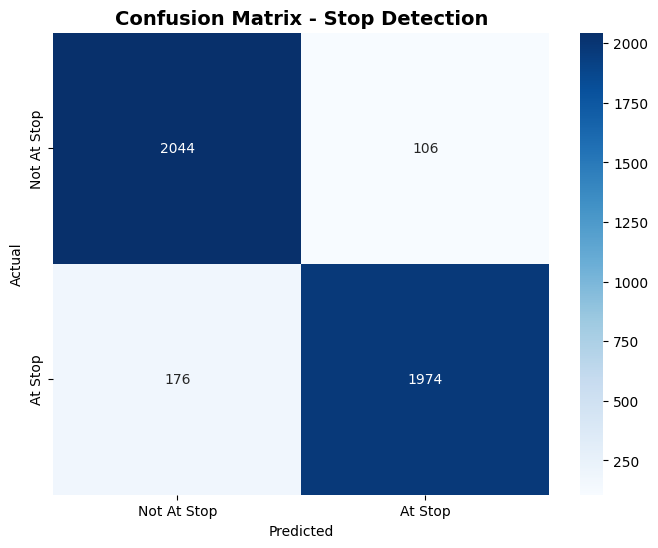

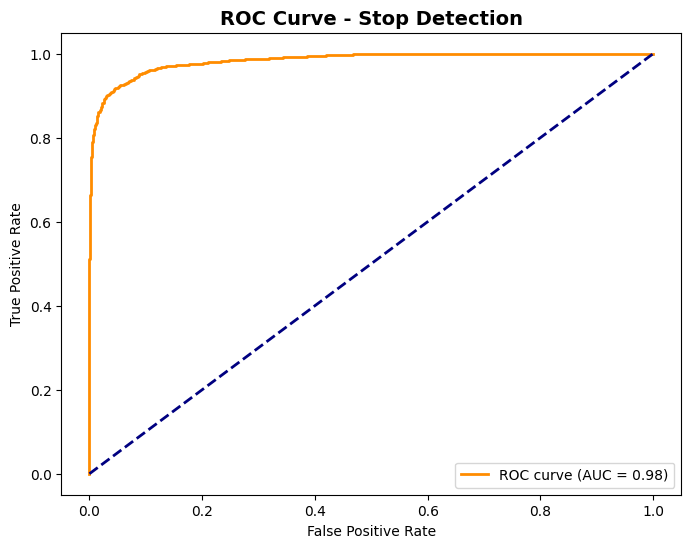

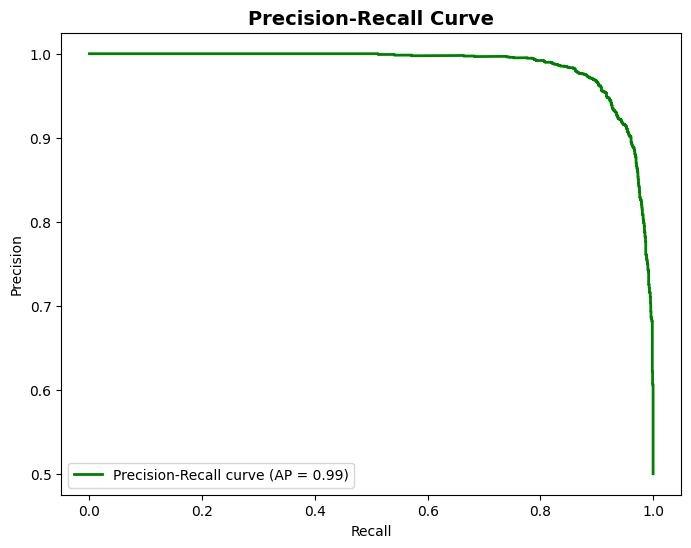

In [48]:
print("Model Evaluation")

#make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

#calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"\nTest Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1:.2%}")

#detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not At Stop', 'At Stop']))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

#visualize confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not At Stop', 'At Stop'],
            yticklabels=['Not At Stop', 'At Stop'])
plt.title('Confusion Matrix - Stop Detection', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stop Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

#recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(recall_curve, precision_curve, color='green', lw=2,
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left")
plt.show()

## **Feature Importance Analysis**

Feature Importance Analysis

Top 10 Most Important Features:
          feature  importance
13        is_slow    0.296501
0             lat    0.104577
1             lng    0.098230
2       speed_mps    0.096593
12      speed_kmh    0.078861
16  high_accuracy    0.044028
6              az    0.039639
3        accuracy    0.034791
4              ax    0.033028
7              gx    0.032112


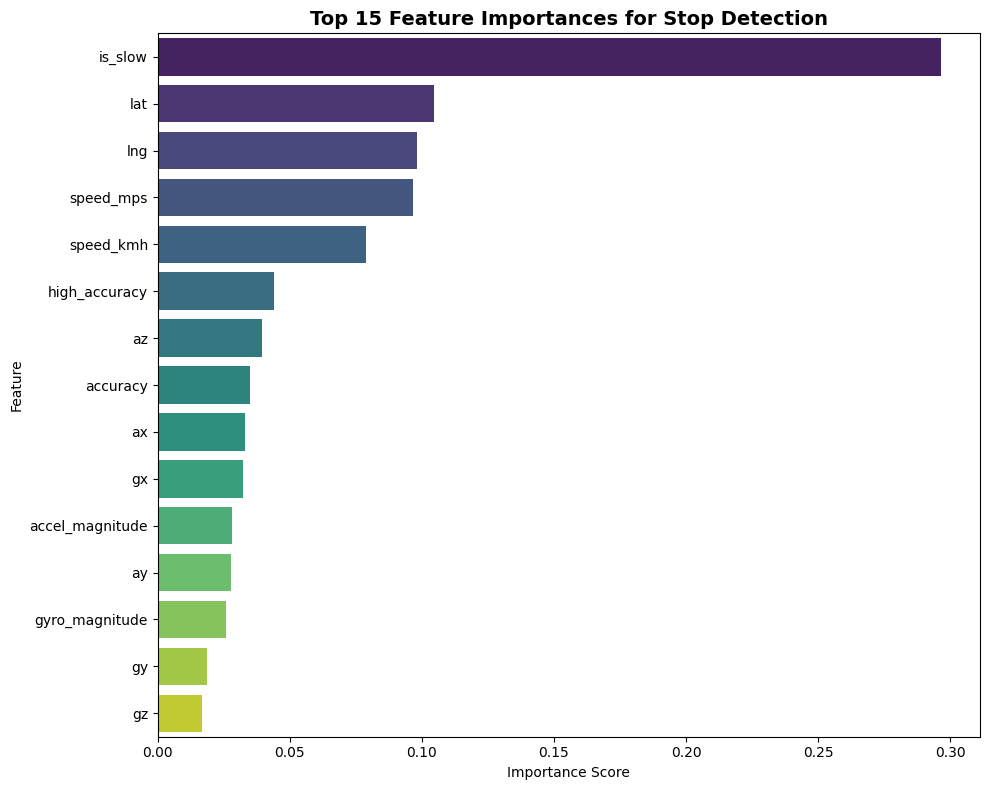

In [49]:
print("Feature Importance Analysis")

#fet feature importance from XGBoost
importance_df = pd.DataFrame({
    'feature': FINAL_FEATURES,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

#visualize
plt.figure(figsize=(10,8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title('Top 15 Feature Importances for Stop Detection', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()




##**Test on Sample Data**


In [50]:
print("Testing Model on Sample Data")

#test on a few random samples
sample_indices = np.random.choice(X_test.index if hasattr(X_test, 'index') else range(len(X_test)),
                                  size=min(10, len(X_test)), replace=False)

print("\nSample Predictions:")
print("-" * 80)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Probability':<15} {'Speed (m/s)':<12}")
print("-" * 80)

for i, idx in enumerate(sample_indices):
    actual = y_test.iloc[i] if hasattr(y_test, 'iloc') else y_test[i]
    predicted = y_pred[i]
    probability = y_pred_prob[i]
    speed = X_test.iloc[i]['speed_mps'] if hasattr(X_test, 'iloc') else X_test[i][2]

    actual_label = 'At Stop' if actual == 1 else 'Not At Stop'
    pred_label = 'At Stop' if predicted == 1 else 'Not At Stop'

    print(f"{idx:<8} {actual_label:<12} {pred_label:<12} {probability:<15.2%} {speed:<12.2f}")


Testing Model on Sample Data

Sample Predictions:
--------------------------------------------------------------------------------
Index    Actual       Predicted    Probability     Speed (m/s) 
--------------------------------------------------------------------------------
2855     At Stop      At Stop      99.54%          0.00        
7777     Not At Stop  Not At Stop  5.50%           7.23        
10058    Not At Stop  Not At Stop  2.01%           5.15        
7764     At Stop      At Stop      98.01%          0.42        
12455    At Stop      At Stop      62.84%          3.50        
10439    Not At Stop  At Stop      70.59%          1.45        
7319     At Stop      At Stop      98.30%          0.00        
6156     At Stop      At Stop      84.35%          4.39        
20137    At Stop      At Stop      93.96%          0.34        
5355     Not At Stop  Not At Stop  28.61%          0.28        


## **Export Models**

In [51]:
print("Exporting Model")

#model filename
MODEL_FILENAME = "TransitLK_ETA_Stop_Detection_XGB.pkl"

#save the trained model
joblib.dump(model, MODEL_FILENAME)

#save metadata
metadata = {
    'model_name': 'TransitLK ETA Stop Detection v1',
    'features': FINAL_FEATURES,
    'detection_radius_meters': DETECTION_RADIUS,
    'threshold': 0.5,
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'training_date': datetime.now().strftime('%Y-%m-%d'),
    'key_stops_r2b': KEY_STOPS_R2B,
    'key_stops_b2r': KEY_STOPS_B2R,
    'route_detection': 'Automatic based on latitude trend'
}

import json
with open('eta_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nModel saved: {MODEL_FILENAME}")
print(f"Metadata saved: eta_model_metadata.json")


print("\nFINAL FEATURE ORDER for Android Implementation:")
for i, feat in enumerate(FINAL_FEATURES, 1):
    print(f"  {i:2d}. {feat}")

print("\nModel Summary:")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-Score: {f1:.2%}")
print(f"Detection Radius: {DETECTION_RADIUS}m")
print(f"Key Stops (R2B): {len(KEY_STOPS_R2B)}")
print(f"Key Stops (B2R): {len(KEY_STOPS_B2R)}")

#save stop coordinates for Android
stops_data = {
    'ratmalana_to_bambalapitiya': {k: {'lat': v[0], 'lng': v[1]}
                                    for k, v in STOPS_RATMALANA_TO_BAMBALAPITIYA.items()},
    'bambalapitiya_to_ratmalana': {k: {'lat': v[0], 'lng': v[1]}
                                    for k, v in STOPS_BAMBALAPITIYA_TO_RATMALANA.items()}
}

with open('bus_stops.json', 'w') as f:
    json.dump(stops_data, f, indent=2)

print(f"Bus stops saved: bus_stops.json")

#download files
files.download(MODEL_FILENAME)
files.download('eta_model_metadata.json')
files.download('bus_stops.json')

print("\nAll files ready for download!")
print("ETA Model Training Complete!")

Exporting Model

Model saved: TransitLK_ETA_Stop_Detection_XGB.pkl
Metadata saved: eta_model_metadata.json

FINAL FEATURE ORDER for Android Implementation:
   1. lat
   2. lng
   3. speed_mps
   4. accuracy
   5. ax
   6. ay
   7. az
   8. gx
   9. gy
  10. gz
  11. accel_magnitude
  12. gyro_magnitude
  13. speed_kmh
  14. is_slow
  15. is_stopped
  16. accel_jerk
  17. high_accuracy

Model Summary:
Accuracy: 93.44%
Precision: 94.90%
Recall: 91.81%
F1-Score: 93.33%
Detection Radius: 50m
Key Stops (R2B): 16
Key Stops (B2R): 16
Bus stops saved: bus_stops.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files ready for download!
ETA Model Training Complete!
